<a href="https://colab.research.google.com/github/felipemorinishi/Projetos-Turing_USP/blob/Projetos_NLP/Projeto_Entrada_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projetinho de ingresso em NLP - Turing USP

Olá NLPers! Sejam bem vindos ao meu notebook do projeto de entrada na área de NLP do Turing USP! Aqui vocês verão uma análise exploratória de alguns livros da maravilhosa escritora Clarice Lispector, bem como uma implementação básica de ferramentas de embeddings, como o Word2Vec e o BERT.

##Importações

Primeiramente, vamos importar as bibliotecas necessárias para realizarmos nossa tarefa.

In [ ]:
!python -m spacy download pt_core_news_lg

2022-11-20 01:06:15.928738: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568.2 MB 13 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [ ]:
%pip install gensim
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import json

import spacy
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

import torch
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForPreTraining

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Processamento do corpus

Aqui iremos importar o nosso corpus (pré-processado), que consiste nos livros "A Hora da Estrela", "Crônicas" e "Todos os Contos". Além disso, iremos transformá-lo em um dataframe para um manuzeio mais prático.

In [ ]:
with open("corpus_tokenizado.json") as file:
  corpus = json.load(file)

In [ ]:
corpus_dict = json.loads(corpus)

Por uma questão de curiosidade, optou-se por dividir o corpus em 3, para ver se existem diferenças entre os três livros.

In [ ]:
df1 = pd.DataFrame(corpus_dict['corpus'][0], columns = ['palavras'])
df2 = pd.DataFrame(corpus_dict['corpus'][1], columns = ['palavras'])
df3 = pd.DataFrame(corpus_dict['corpus'][2], columns = ['palavras'])

####Limpeza dos datasets

Agora podemos começar a fazer uma observação inicial dos datasets e, caso haja algo estranho, poderemos limpá-los.

#####"A Hora da Estrela"

In [ ]:
df1.head()

,palavras
0,dados
1,de
2,copyright
3,sobre
4,a


Aqui já notamos algumas palavras que aparentemente não pertencem à obra. Isso ocorreu porque o corpus foi importado do site LeLivros, de modo que temos que remover uma pequena introdução deixada por eles.

In [ ]:
#Com muita insistência e uso de iloc's, chegou-se a conclusão que a parte a ser removida acaba com a palavra nível
start_l1 = 0
stop_l1 = df1.loc[df1['palavras'] == 'nível'].index[0]

In [ ]:
#dropando a parte necessária
df1 = df1.drop(df1.index[start_l1:stop_l1+1])

In [ ]:
#Novo dataset
df1.head()

,palavras
149,a
150,hora
151,da
152,estrela
153,clarice


#####"Cronicas"

In [ ]:
df2.head()

,palavras
0,sumário
1,para
2,pular
3,o
4,sumário


Aqui temos o mesmo caso do primeiro livro, tal que iremos repetir o mesmo procedimento.

In [ ]:
print(df2.iloc[0:30])

    palavras
0    sumário
1       para
2      pular
3          o
4    sumário
5     clique
6       aqui
7   prefácio
8     jornal
9         do
10    brasil
11   jornais
12         e
13  revistas
14         o
15    jornal
16    senhor
17      joia
18    última
19      hora
20      para
21       não
22  esquecer
23  posfácio
24    índice
25  créditos
26         a
27    autora
28  prefácio
29       nem


Aqui vemos que as palavras até o index 27 correspondem ao sumário do livro. Como é um texto que não possui sentido entre suas partes iremos descartá-lo. No entanto, optou-se por deixar o prefácio, porque mesmo não sendo de autoria da Clarice, é um texto que possui algum tipo de sentido e, portanto, pode ser interessante deixá-lo.

In [ ]:
#Dropando o sumário
df2 = df2.drop(df2.index[0:28])

In [ ]:
#Novo dataset
df2.head()

,palavras
28,prefácio
29,nem
30,uma
31,vírgula
32,aquela


#####"Todos os Contos"

In [ ]:
df3.head()

,palavras
0,dados
1,de
2,copyright
3,sobre
4,a


Novamente, iremos repetir o procedimento, tirando a introdução do site e o sumário.

In [ ]:
#Utilizando o iloc, concluimos que o sumário termina com a palavra autora
start_l3 = 0
stop_l3 = df3.loc[df3['palavras'] == 'autora'].index[0]

In [ ]:
#dropando o desnecessário
df3 = df3.drop(df3.index[start_l3:stop_l3+1])

In [ ]:
#novo dataset
df3.head()

,palavras
474,glamour
475,e
476,gramática
477,r
478,enunciais


####Stopwords

Utilizaremos a biblioteca NLTK para retirar as stopwords do nosso corpus, que são palavras consideradas irrelevantes para a construção de modelos de análise de texto.

In [ ]:
#Iremos adicionar outras palavras, que são abreviações de palavras já presentes no corpus de stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.append("pra")
stopwords.append("tá")
stopwords.append("dá")
stop = set(stopwords)

Agora iremos dropar todas as palavras contidas na lista de stopwords nos três datasets.

In [ ]:
df1 = df1[~df1['palavras'].isin(stop)]
df2 = df2[~df2['palavras'].isin(stop)]
df3 = df3[~df3['palavras'].isin(stop)]

####Lematização

Antes de começar a análise, iremos realizar o processo de lematização, que consiste na redução das palavras em seus termos mais simples, em suas raízes, semelhante ao que ocorre em dicionários. Isso é feito para evitar que se trabalhe com variações de palavras que querem dizer a mesma coisa, bem como deixar mais propício que um modelo faça relações entre sinônimos.

Aqui utilizaremos a biblioteca spacy na sua versão em português.

In [ ]:
nlp = spacy.load("pt_core_news_lg")
nlp.max_length = 1500000

Vamos transformar cada um dos nossos datasets em strings, para que possamos realizar a lematização.

In [ ]:
doc1 = nlp(str([palavra for palavra in df1['palavras']]))
doc2 = nlp(str([palavra for palavra in df2['palavras']]))
doc3 = nlp(str([palavra for palavra in df3['palavras']]))

Utilizando o spacy, iremos criar novos datasets que contém, alé, da própria palavra, seu lema, sua classe gramatical e se é considerada uma stopword.

In [ ]:
def lematizador(doc):
  cols = ['Palavra', 'Lema', 'POS', 'Classe', 'Stopword']
  rows = []
  for n in doc:
    row = [n.text, n.lemma_, n.pos_, spacy.explain(n.pos_), n.is_stop]
    if n.pos_ != 'PUNCT' and n.text != "'":
      rows.append(row)
  df = pd.DataFrame(rows, columns = cols)
  return df

In [ ]:
df_lema1 = lematizador(doc1)
df_lema2 = lematizador(doc2)
df_lema3 = lematizador(doc3)

In [ ]:
df_lema1.head()

,Palavra,Lema,POS,Classe,Stopword
0,hora,hora,NOUN,noun,False
1,estrela,estrela,NOUN,noun,False
2,clarice,clarice,NOUN,noun,False
3,lispector,lispector,NOUN,noun,False
4,hora,hora,NOUN,noun,False


In [ ]:
df_lema2.head()

,Palavra,Lema,POS,Classe,Stopword
0,prefácio,prefácio,NOUN,noun,False
1,vírgula,vírgulo,ADJ,adjective,False
2,sexta,sexta,NOUN,noun,True
3,feira,feira,NOUN,noun,False
4,agosto,agosto,NOUN,noun,False


In [ ]:
df_lema2.head()

,Palavra,Lema,POS,Classe,Stopword
0,prefácio,prefácio,NOUN,noun,False
1,vírgula,vírgulo,ADJ,adjective,False
2,sexta,sexta,NOUN,noun,True
3,feira,feira,NOUN,noun,False
4,agosto,agosto,NOUN,noun,False


####Frequências

#####Classes gramaticais 

Agora vamos plotar os gráficos de frequência das classes gramaticais de cada livro

In [ ]:
#Aqui elencamos as classes gramaticais em listas para subsequentemente ordená-las nos gráficos
classes = ['NOUN', 'VERB', 'ADV', 'ADJ', 'PRON', 'PROPN', 'ADP', 'SCONJ', 'DET', 'CCONJ', 'NUM', 'AUX', 'INTJ']
data = [df_lema1, df_lema2, df_lema3]

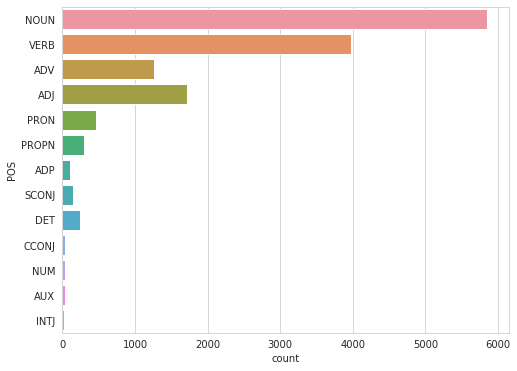

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(y='POS', data=df_lema1, order=classes)
sns.set_style('whitegrid')
plt.show()

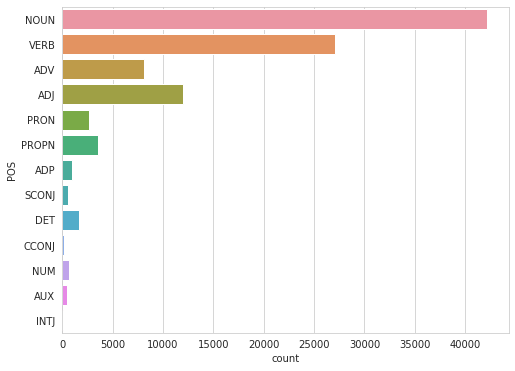

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(y='POS', data=df_lema2, order=classes)
sns.set_style('whitegrid')
plt.show()

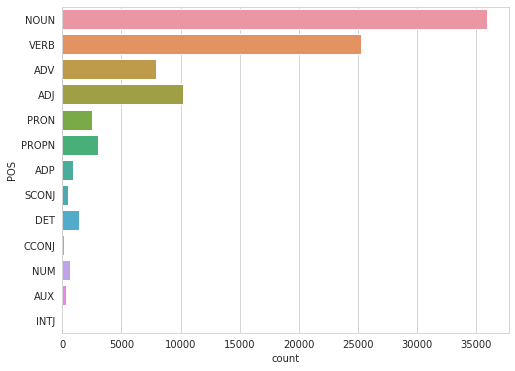

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(y='POS', data=df_lema3, order=classes)
sns.set_style('whitegrid')
plt.show()

Vemos que a frequência relativa entre as classes gramaticais não varia muito de livro para livro, indicando, talvez, um estilo de escrita comum a autora, ou ao próprio gênero literário.

#####N-gramas

Uma coisa que podemos fazer são os *n-grams*, uma maneira de medir quais *n* palavras aparecem mais frequantemente em sequência. Neste caso serão analisados os bigramas, ou seja, conjuntos de duas palavras.

In [ ]:
lema_1 = df_lema1['Lema']
lema_2 = df_lema2['Lema']
lema_3 = df_lema3['Lema']

In [ ]:
bigramas_1 = (pd.Series(nltk.ngrams(lema_1, 2)).value_counts())[:10]
bigramas_2 = (pd.Series(nltk.ngrams(lema_2, 2)).value_counts())[:10]
bigramas_3 = (pd.Series(nltk.ngrams(lema_3, 2)).value_counts())[:10]

<function matplotlib.pyplot.show(*args, **kw)>

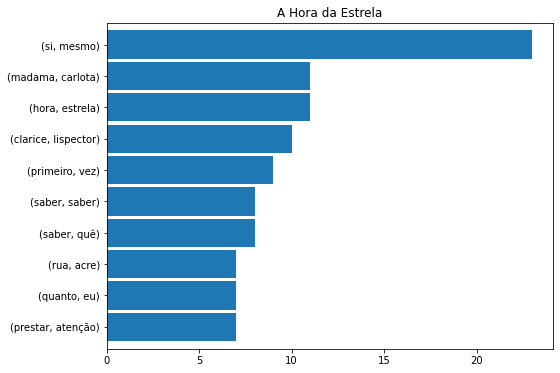

In [ ]:
plt.title('A Hora da Estrela')
bigramas_1.sort_values().plot.barh( width=.9, figsize=(8, 6))
plt.show

No corpus do livro "A Hora da Estrela" podemos ver algumas peculiariedades da obra presente nos bigramas mais frequentes. Por exemplo, vemos a presença do bigrama *(madama, carlota)*, que se refere à personagem madame carlota. Temos ainda o bigrama *(rua, acre)*, que representa a Rua do Acre local onde a protagonista Macabéa vai morar quando se muda para o Rio de Janeiro.

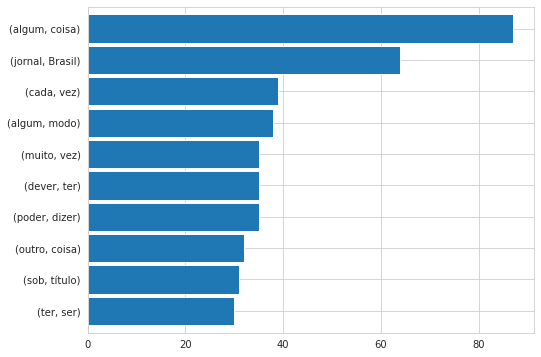

In [ ]:
bigramas_2.sort_values().plot.barh(width=.9, figsize=(8, 6))

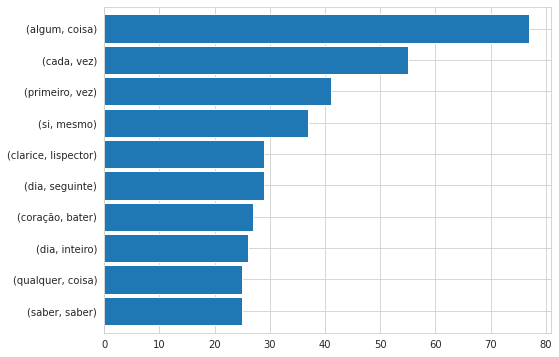

In [ ]:
bigramas_3.sort_values().plot.barh(width=.9, figsize=(8, 6))

Quanto aos outros dois livros não podemos observar nada que se ligue diretamente às tramas, já que neles estão contidos muitos contos diferentes. É mais comum a presença de bigramas como *(algum, coisa)* e *(cada, vez)* que representam construções sintáticas mais comuns da lingua portuguesa.

#####Wordcloud

Por último, iremos finalizar a análise com um panorama geral dos três livros, utilizando o WordCloud, uma forma de visualizar a questão das frequência de palavras de maneira compacta.

######Geral

In [ ]:
p1 = " ".join(s for s in lema_1.values)
p2 = " ".join(s for s in lema_2.values)
p3 = " ".join(s for s in lema_3.values)

In [ ]:
wc1 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(p1)
wc2 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(p2)
wc3 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(p3)

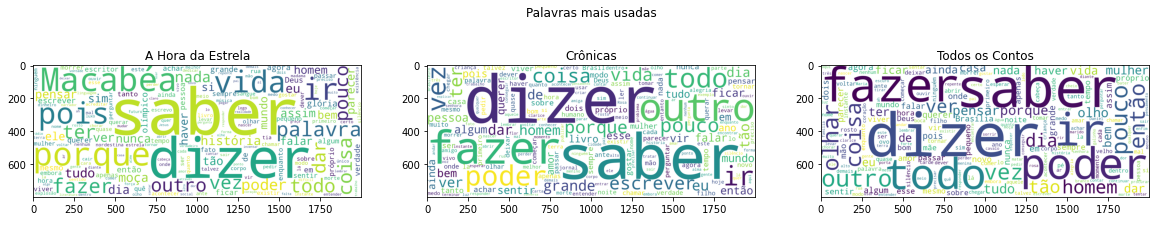

In [ ]:
fig = plt.figure(figsize=(20,4))

plt.title('Palavras mais utilizadas')
plt.axis("off")
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(wc1)
ax1.set_title('A Hora da Estrela')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(wc2)
ax2.set_title('Crônicas')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(wc3)
ax3.set_title('Todos os Contos')

plt.show()

No livro "A Hora da Estrela" vemos novamente o contraste com os demais. Podemos observar a presença do nome da protagonista principal, Macabéa, ao passo que nos outros vemos em maior destaque a presença de palavras mais comuns da lingua portuguesa, em virtude da quantidade de contos e crônicas presentes em cada um deles.

######Verbos

In [ ]:
verbos1 = df_lema1[df_lema1['POS'] == 'VERB']['Lema']
verbos2 = df_lema2[df_lema2['POS'] == 'VERB']['Lema']
verbos3 = df_lema3[df_lema3['POS'] == 'VERB']['Lema']

In [ ]:
v1 = ' '.join(s for s in verbos1.values)
v2 = ' '.join(s for s in verbos2.values)
v3 = ' '.join(s for s in verbos3.values)

In [ ]:
wc_verbo1 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(v1)
wc_verbo2 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(v2)
wc_verbo3 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(v3)

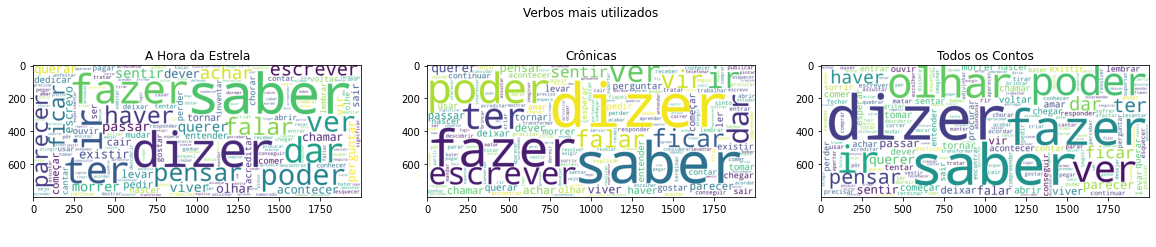

In [ ]:
fig = plt.figure(figsize=(20,4))

plt.title('Verbos mais utilizados')
plt.axis("off")
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(wc_verbo1)
ax1.set_title('A Hora da Estrela')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(wc_verbo2)
ax2.set_title('Crônicas')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(wc_verbo3)
ax3.set_title('Todos os Contos')

plt.show()

Em relação aos verbos, não vemos grande diferença entre os livros, sendo os mais comuns *dizer*, *saber* e *dizer*.

######Substantivos

In [ ]:
subs1 = df_lema1[df_lema1['POS'] == 'NOUN']['Lema']
subs2 = df_lema2[df_lema2['POS'] == 'NOUN']['Lema']
subs3 = df_lema3[df_lema3['POS'] == 'NOUN']['Lema']

In [ ]:
s1 = ' '.join(s for s in subs1.values)
s2 = ' '.join(s for s in subs2.values)
s3 = ' '.join(s for s in subs3.values)

In [ ]:
wc_sub1 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(s1)
wc_sub2 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(s2)
wc_sub3 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(s3)

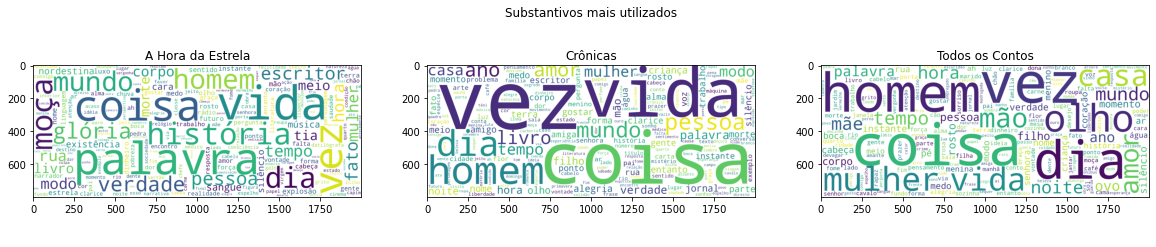

In [ ]:
fig = plt.figure(figsize=(20,4))

plt.title('Substantivos mais utilizados')
plt.axis("off")
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(wc_sub1)
ax1.set_title('A Hora da Estrela')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(wc_sub2)
ax2.set_title('Crônicas')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(wc_sub3)
ax3.set_title('Todos os Contos')

plt.show()

Novamente vemos uma diferença em "A Hora da Estrela", agora talvez mais sutil, no que se refere a discrepância entre os substantivos mais usados e o restante. Ainda que os mais usados sejam os mesmos nos outros livros, a diferença de tamanho não é tão grande, indicando, mais que uma variedade maior, a maior presença de termos específicos aquela trama.

######Adjetivos

In [ ]:
adj1 = df_lema1[df_lema1['POS'] == 'ADJ']['Lema']
adj2 = df_lema2[df_lema2['POS'] == 'ADJ']['Lema']
adj3 = df_lema3[df_lema3['POS'] == 'ADJ']['Lema']

In [ ]:
a1 = ' '.join(s for s in adj1.values)
a2 = ' '.join(s for s in adj2.values)
a3 = ' '.join(s for s in adj3.values)

In [ ]:
wc_adj1 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(a1)
wc_adj2 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(a2)
wc_adj3 = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(a3)

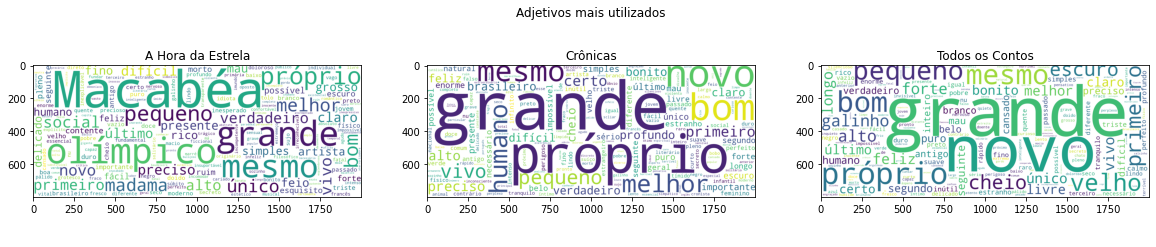

In [ ]:
fig = plt.figure(figsize=(20,4))

plt.title('Adjetivos mais utilizados')
plt.axis("off")
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(wc_adj1)
ax1.set_title('A Hora da Estrela')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(wc_adj2)
ax2.set_title('Crônicas')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(wc_adj3)
ax3.set_title('Todos os Contos')

plt.show()

A diferença ocorre também nos adjetivos. Aparentemente considerou-se "Macabéa e olímpico como adjetivos mas são dois personagens da trama.

##Word2Vec

Já feita a análise, vamos nos focar agora em *embeddings*. Para isso utilizaremos o Word2Vec, que permite a manipulação de palavras a partir de sua vetorização.

Primeiramente iremos juntar os três livros em um único dataset, para que possamos treinar nosso modelo de maneira mais eficiente.

In [ ]:
df_lema = pd.concat([df_lema1, df_lema2, df_lema3], ignore_index=True)

In [ ]:
palavras = df_lema['Lema']

A fim de treinar o modelo, precisamos enviar listas de palavras. Desse modo, vamos dividir o dataset em listas de 2 palavras. É um número arbitrário para representar o número de termos que existiria em uma frase.

In [ ]:
vocab = np.array_split(palavras,(len(palavras)-1)/2)
vocab =  [l.tolist() for l in vocab]

Agora, vamos definir o modelo...

In [ ]:
modelo = gensim.models.Word2Vec(
    size=80,
    window=2,
    min_count=5
)

... Adicionar o vocabulário ...

In [ ]:
modelo.build_vocab(vocab, progress_per=2000)

... E treinar!

In [ ]:
modelo.train(vocab, total_examples=modelo.corpus_count, epochs=modelo.epochs)

(858728, 1016395)

Finalmente, podemos analisar algumas propriedades dos nosso embeddings.

A primeira coisa seria testar a similaridade de cossenos entre duas palavras do corpus. É, resumidademente, uma medida para saber se os vetores dessas duas palavras "apontam" para a mesma direção.

In [ ]:
modelo.wv.similarity('Macabéa', 'moça')

0.9995483

Aqui podemos ver que as palavras *Macabéa* e *moça* são bastante próximas. Intuitivamente faz sentido, visto que designam coisas semelhantes.

In [ ]:
modelo.wv.similarity('Macabéa', 'pedra')

0.99946

Aqui, no entanto, vemos algo estranho. Intuitivamente, essas duas palavras designam coisas bem distintas, mas mesmo assim possuem uma similaridade bem alta. Isso se deu, talvez, porque os parâmetros não foram tunados corretamente quando se construiu o modelo, ou, ainda, porque os dados de treino não foram satisfatórios.

In [ ]:
def dist_euclidiana(u,v):
  return np.linalg.norm(u - v)

In [ ]:
dist_euclidiana(modelo.wv['pois'], modelo.wv['porque'])

0.07116026

Também podemos calcular a distância euclidiana entre os vetores das palavras. Neste caso a distância é pequena, indicando a semelhança das duas palavras.

Além disso, podemos mostrar quais termos são os mais similares em relação a uma palavra escolhida.

In [ ]:
modelo.wv.most_similar(positive='Macabéa')

[('trabalho', 0.9997382760047913),
 ('único', 0.9996837973594666),
 ('sala', 0.99965500831604),
 ('fim', 0.9996536374092102),
 ('resposta', 0.999650239944458),
 ('paixão', 0.9996482133865356),
 ('enfim', 0.9996467232704163),
 ('esperança', 0.9996432065963745),
 ('explicação', 0.999640703201294),
 ('profundo', 0.9996370673179626)]

Vemos que o modelo falha, de certo ângulo, no que se refere a tarefa, já que o nome da protagonista de "A Hora da Estrela" possui uma similaridade grande com termos inusitados como "ah", "profundo" e "simplesmente". Talvez seja porque tenham sido empregadas em contextos parecidos.

Por fim, podemos identificar palavras que não se encaixam em uma determinada lista de palavras.

In [ ]:
modelo.wv.doesnt_match(['dizer', 'falar', 'café'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'café'

Vemos aqui que a tarefa se deu de maneira satisfatória.

###NILC

Para poder contornar alguns dos problemas encontrados acima, podemos também utilizar modelos previamente treinados. Vamos utilizar o NILC em duas posições vetoriais: com 50 e 300 dimensões. Optamos por não utilizar com 1000 dimensões porque era muito pesado.

####50 dimensões

Primeiro vamos carregar nosso modelo:

In [ ]:
!wget -cO - http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s50.zip > cbow_s50.zip
!unzip cbow_s50.zip

--2022-11-20 01:16:14--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s50.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170360268 (162M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 162.47M  11.2MB/s    in 16s     

2022-11-20 01:16:30 (10.3 MB/s) - written to stdout [170360268/170360268]

Archive:  cbow_s50.zip
replace cbow_s50.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cbow_s50.txt            


In [ ]:
modelo_50 = gensim.models.KeyedVectors.load_word2vec_format('cbow_s50.txt')

Agora, vamos fazer alguns testes.

In [ ]:
modelo_50.similarity('macabéa', 'pedra')

0.4978895

Como o treinamento foi feito com muito mais dados e de maneira muito mais sofisticada, vemos que a similaridade entre "macabéa" e "pedra" já não é mais tão alta.

Agora vamos testar palavras que não são necessariamente específicas da obra de Clarice.

In [ ]:
modelo_50.similarity('árvore', 'planta')

0.8427614

In [ ]:
dist_euclidiana(modelo_50['árvore'], modelo_50['planta'])

1.1143357

In [ ]:
modelo_50.most_similar('árvore')

[('franja', 0.9006020426750183),
 ('vasilha', 0.896187961101532),
 ('sebe', 0.896075427532196),
 ('rapariguita', 0.8950937390327454),
 ('clarabóia', 0.8903752565383911),
 ('lamparina', 0.8900789022445679),
 ('viga', 0.88938307762146),
 ('carranca', 0.8892046213150024),
 ('redoma', 0.8883304595947266),
 ('montanha-russa', 0.8876838088035583)]

Aqui podemos perceber que as palavras "árvore" e "planta" possuem valores de similaridade de cossenos e de distância euclidiana bastante razoáveis. No entanto, quando observamos as palavras mais similares a árvore, vemos que elas não fazem tanto sentido.

In [ ]:
modelo_50.doesnt_match(['estrela', 'céu', 'café'])

'estrela'

Aqui vemos que o modelo "errou" na hora de distinguir a palavra correta.

Conclui-se modelo pré treinado conseguiu melhorar algumas das coisas que o nosso modelo falhou em obter. Porém, ainda possui alguns erros.

####300 dimensões

In [ ]:
!wget -cO - http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s300.zip > cbow_s300.zip
!unzip cbow_s300.zip

--2022-11-20 01:17:54--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 929305948 (886M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 886.25M  11.2MB/s    in 80s     

2022-11-20 01:19:14 (11.1 MB/s) - written to stdout [929305948/929305948]

Archive:  cbow_s300.zip
  inflating: cbow_s300.txt           y



In [ ]:
modelo_300 = gensim.models.KeyedVectors.load_word2vec_format('cbow_s300.txt')

Carregado o modelo, agora com 300 dimensões, vamos fazer os mesmos testes.

In [ ]:
modelo_300.similarity('macabéa', 'pedra')

0.22423476

Aqui vemos que a similaridade caiu ainda mais, demonstrando uma aparente melhora do modelo.

In [ ]:
modelo_300.similarity('árvore', 'planta')

0.5631748

In [ ]:
dist_euclidiana(modelo_300['árvore'], modelo_300['planta'])

3.1493657

In [ ]:
modelo_300.most_similar('árvore')

[('ã¡rvore', 0.6181504726409912),
 ('trepadeira', 0.5933765769004822),
 ('ribanceira', 0.5871323347091675),
 ('sebe', 0.5637330412864685),
 ('planta', 0.5631747841835022),
 ('sequóia', 0.5481311678886414),
 ('guirlanda', 0.5474179983139038),
 ('baforada', 0.5457673072814941),
 ('lasca', 0.5441134572029114),
 ('gruta', 0.5431685447692871)]

No caso das palavras "árvore" e "planta", temos que, surpreendentemente, tanto a similaridade quanto a distância pioraram. Isso, no entanto, foi acompanhado de uma melhora no que se refere à seleção dos termos mais similares. Como pode ser visto acima, as palavras em questão condizem muito mais com a semântica da palavra árvore.

In [ ]:
modelo_300.doesnt_match(['estrela', 'céu', 'café'])

'café'

O novo modelo também conseguiu distinguir a palavra "café" das demais.

Podemos concluir, ao final de tudo isso, que os modelos pré treinados são, em parte, mais confiáveis do que o modelo que treinamos neste notebook. Ainda que não sejam perfeitos, eles fazem são capazes de capturar o sentido das palavras de maneira muito melhor. Além disso, o desempenho melhorou conforme aumentamos as dimensões (50 - 300), porém não foi possível confirmar até que ponto isso é verdade.

### Frases

Ainda utilizando o Word2Vec, vamos fazer novos *embeddings*, não de palavras, mas de frases inteiras. Esse processo consiste em fazer a média dos vetores de cada palavra da frase.

Agora, vamos construir e treinar nosso modelo:

In [ ]:
bigrams = gensim.models.phrases.Phrases(vocab)

In [ ]:
modelo_frases = gensim.models.Word2Vec(
    size=80,
    window=2,
    min_count=5
)

In [ ]:
modelo_frases.build_vocab(bigrams[vocab], progress_per=10000)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
modelo_frases.train(bigrams[vocab], total_examples=modelo_frases.corpus_count, epochs=modelo_frases.epochs, report_delay=1)

(855627, 1012065)

In [ ]:
vetor_palavra = modelo_frases.wv

Já tendo treinado o modelo, vamos elaborar uma função que calcule a similaridade de cossenos entre duas frases utilizando a média dos embeddings de cada palavra da frase.

In [ ]:
def sim_cos_frase(a, b):
  frase_a = a.split()
  frase_b = b.split()
  emb_a = emb_b = 0
  emb_frases = []
  for n in frase_a:
    emb_a += vetor_palavra[n]
  for m in frase_b:
    emb_b += vetor_palavra[m]
  emb_frases.append(emb_a/len(frase_a))
  emb_frases.append(emb_b/len(frase_b))
  sim = np.dot(emb_frases[0], emb_frases[1])/(np.linalg.norm(emb_frases[0])*np.linalg.norm(emb_frases[1]))
  return sim


Por fim, vamos testar nossos embeddings:

In [ ]:
sim_cos_frase('eu gosto de ler', 'eu gosto de comida')

0.9999371

In [ ]:
sim_cos_frase('eu gosto de livro', 'que noite tranquila')

0.9993754

Podemos ver, porém, que mesmo que a frase seja muito diferente, elas apresentam similaridades semelhantes, de modo que o modelo de frases apresenta o mesmo problema do primeiro modelo aqui treinado.

##BERT

Por último, iremos explorar o BERT, um modelo mais atual de *embeddings*. Ele utiliza o conceito de *Transformer*, que se refere a uma técnica de *encoding* e *decoding* inspirada no mecanismo cognitivo de atenção, presente nos animais. O BERT utiliza somente a parte de *encoding*, transformando as palavras em vetores, assim como no Word2Vec, mas levando em conta o contexto no qual elas estão inseridas. 

No nosso caso, utilizaremos a versão pré treinada em português, o BERTIMBAU.

Novamente, iremos carregar o modelo e adicionaremos também o tokenizador.

In [ ]:
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Agora iremos definir uma função para fazer os embeddings das frases. Assim como no Word2Vec, o embedding da frase nada mais é do que uma média dos vetores de cada palavra da frase, com a única diferença sendo que agora é um token.

In [ ]:
def sentence_embedding_bert(text):
  marked_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)

  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  model.eval()

  with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    encoded_layers = outputs[0]
  
  token_vecs = encoded_layers[0, 1:-1] 
  return torch.mean(token_vecs, dim=0)

Feito isso, podemos analisar as relações entre algumas frases, tanto sua similaridade quanto a distância entre elas.

In [ ]:
sent1 = sentence_embedding_bert("Eu gosto da Clarice")
sent2 = sentence_embedding_bert("Eu gosto de ler Clarice")

torch.cosine_similarity(sent1.reshape(1,-1), sent2.reshape(1,-1))


tensor([0.8679])

In [ ]:
(sent1 - sent2).pow(2).sum().sqrt()

tensor(3.5944)

Voltando para a obra de Clarice Lispector, iremos utilizar algumas frases retiradas do livro "A hora da Estrela" e verificar a similaridade entre elas.

Os trechos foram retirados neste site: https://www.todamateria.com.br/a-hora-da-estrela-de-clarice-lispector/#:~:text=“A%20Hora%20da%20Estrela”%20é,pertencente%20à%20Terceira%20Geração%20Modernista.

In [ ]:
frases = ["Imaginavazinha, toda supersticiosa, que se por acaso viesse alguma vez a sentir um gosto bem bom de viver",
          "Então defendia-se da morte por intermédio de um viver de menos",
          "Teria ela a sensação de que vivia para nada",
          "Todas as madrugadas ligava o rádio emprestado por uma colega de moradia",
          "Cada gota de minuto que passava",
          "E sobretudo esse canal de rádio aproveitava intervalos entre as tais gotas de minuto para dar anúncios comerciais",
          "Era rádio perfeita pois também entre os pingos do tempo dava curtos ensinamentos",
          "Aí Macabéa disse uma frase que nenhum dos transeuntes entendeu",
          "Nesta hora exata Macabéa sente um fundo enjôo de estômago e quase vomitou"]

Agora, vamos definir uma função que constrói uma matriz que armazena a similaridade de cossenos dos embeddings de cada frase.

In [ ]:
def heatmap_matrix(corpus_sent):
  length = len(corpus_sent)
  heat_matrix = np.zeros((length,length))
  for m in range(length):
    sent1 = sentence_embedding_bert(corpus_sent[m])
    for n in range(length):
      sent2 = sentence_embedding_bert(corpus_sent[n])
      heat_matrix[m][n] = float(torch.cosine_similarity(sent1.reshape(1,-1), sent2.reshape(1,-1)))
  return heat_matrix

In [ ]:
#armazenando a matriz em uma variável
sentences_heat = heatmap_matrix(frases)

Iremos representá-la por meio de um heatmap.

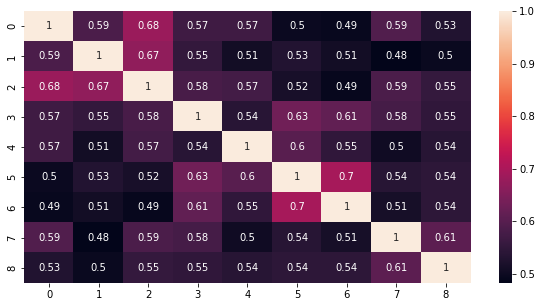

In [ ]:
plt.figure(figsize=[10,5])
sns.heatmap(sentences_heat, annot = True)

Vemos que a maioria não apresenta uma grande similaridade, talvez em função do tamanho e complexidade de cada uma. Assim, iremos analisar aquelas cuja similaridade seja maior que 0.65:

In [ ]:
index = np.where((sentences_heat > 0.65) & (sentences_heat < 0.975))

In [ ]:
listofcc= list(zip(index[0], index[1]))
cc = list(set(listofcc))

In [ ]:
for coordinates in cc:
  print(f"({frases[coordinates[0]]}) e ({frases[coordinates[1]]})\n")

(Então defendia-se da morte por intermédio de um viver de menos) e (Teria ela a sensação de que vivia para nada)

(E sobretudo esse canal de rádio aproveitava intervalos entre as tais gotas de minuto para dar anúncios comerciais) e (Era rádio perfeita pois também entre os pingos do tempo dava curtos ensinamentos)

(Teria ela a sensação de que vivia para nada) e (Então defendia-se da morte por intermédio de um viver de menos)

(Teria ela a sensação de que vivia para nada) e (Imaginavazinha, toda supersticiosa, que se por acaso viesse alguma vez a sentir um gosto bem bom de viver)

(Imaginavazinha, toda supersticiosa, que se por acaso viesse alguma vez a sentir um gosto bem bom de viver) e (Teria ela a sensação de que vivia para nada)

(Era rádio perfeita pois também entre os pingos do tempo dava curtos ensinamentos) e (E sobretudo esse canal de rádio aproveitava intervalos entre as tais gotas de minuto para dar anúncios comerciais)



Agora, vamos analisar a segunda combinação de frases:

In [ ]:
frase1 = sentence_embedding_bert("Era rádio perfeita pois também entre os pingos do tempo dava curtos ensinamentos")
frase2 = sentence_embedding_bert("E sobretudo esse canal de rádio aproveitava intervalos entre as tais gotas de minuto para dar anúncios comerciais")
torch.cosine_similarity(frase1.reshape(1,-1), frase2.reshape(1,-1))

tensor([0.6950])

In [ ]:
(frase1 - frase2).pow(2).sum().sqrt()

tensor(5.2065)

Além de possuirem a palavra "rádio" em comum, existem termos semelhantes nas duas frases que poodem ter contribuido para um aumento na similaridade entre elas. Dentre eles podemos citar "pingos" e "gotas", bem como "tempo" e "minuto", e "dava" e "dar". Ou seja, mesmo sem ter palavras iguais, aparentemente conseguiu-se captar o sentido da frase de maneira satisfatória, uma melhora em relação ao Word2Vec.

##Conclusões

Neste projeto, buscamos aprender sobre os conceitos básicos de NLP, a partir da análise do corpus de alguns livros de Clarice Lispector. Utilizamos tanto ferramentas de análise quantitativa quanto de *embeddings*, de modo que foi bem proveitoso para se familiarizar com elas.

Quanto à análise do corpus, conseguimos extrair informações mais significativas do livro "A Hora da Estrela", porque nos demais haviam diversos contos e crônicas, o que impedia a captura de aspectos mais específicos. No entanto, ainda foi possível tirar informações relevantes, no que se refere à análise quantitativa.

Utilizando as ferramentas de *embedding*, pudemos entender melhor como os modelos são treinados, ainda que talvez seja melhor utilizar um pré-treinado. Também foi interessante observar como o BERT conseguiu capturar o contexto das frases de maneira satisfatória.